Set configuration for this measurement

In [337]:
config_path = r'power_dep_resonator.toml'
# config_path = r'power_dep_resonator.toml'


import tomlkit

# Assuming 'config.toml' is your file
with open(config_path, 'r') as file:
    content = file.read()
    sweepLF_config = tomlkit.parse(content)



config parser

In [338]:


vna_address = sweepLF_config["hardware"]["address"]
vna_model = sweepLF_config["hardware"]["model"]
vna_port = sweepLF_config["hardware"]["port"]

measurements = sweepLF_config["measurement"]
attenuation = sweepLF_config["hardware"]["attenuation"]



Load packages

In [339]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from datetime import datetime
from os import makedirs
from os.path import exists


Connect with VNA

In [340]:

from driver import get_VNA

vna = get_VNA(vna_address,vna_model)

vna.check_error()




Connected to: Keysight Technologies,E5080B,MY59101342,A.14.10.08

Clear Status: 6
VNA_E5080B object has been deleted
VNA_E5080B object connection is closed.
Instrument Error: +0,"No error"



Measurement

In [341]:


for m_task in measurements:
    print(m_task)

    output_folder = m_task["output"]
    label = m_task["label"]

    freq_start = m_task["frequency"]["start"]
    freq_stop = m_task["frequency"]["stop"]
    sweep_point = m_task["frequency"]["points"]
    vna_power = m_task["power"]

    IF_bandwidth = m_task["frequency"]["points"]
    repeat = m_task["repeat"]
    IF_bandwidth = m_task["IF_bandwidth"]
    
    for i in range(repeat):
        print(f"measurement: {i}/{repeat}")
        # Set start and stop frequencies

        
        start_time = datetime.now()
        freq_array, s_params  = vna.lin_freq_sweep( freq_start, freq_stop, sweep_point, vna_port, power=vna_power, IF_bandwith=IF_bandwidth)
        end_time = datetime.now()
        # Creating an xarray dataset
        output_data = {
            "s21": ( ["s_params","frequency"],
                    np.array([s_params.real, s_params.imag]) )
        }
        dataset = xr.Dataset(
            output_data,
            coords={ "s_params":np.array(["real","imag"]), "frequency": freq_array })
        

        dataset.attrs["IF_bandwidth"] = IF_bandwidth
        dataset.attrs["power"] = vna_power
        dataset.attrs["attenuation"] = attenuation

        dataset.attrs["start_time"] = str(start_time.strftime("%Y%m%d_%H%M%S"))
        dataset.attrs["end_time"] = str(end_time.strftime("%Y%m%d_%H%M%S"))

        if not exists(output_folder):
            makedirs(output_folder)
            print(f"Create subfolder {output_folder} in result!")

        dataset.to_netcdf( f"{output_folder}\\{label}_{start_time.strftime('%Y%m%d_%H%M%S')}.nc")



{'label': 'C45312', 'IF_bandwidth': 20, 'power': -50.0, 'repeat': 1, 'output': 'C:\\Users\\ASUS\\Documents\\python training\\THINFAT\\raw\\C45312\\att80_-50.0', 'frequency': {'start': 4531100000.0, 'stop': 4531300000.0, 'points': 501}}
measurement: 0/1
Sweep completed: +1

Create subfolder C:\Users\ASUS\Documents\python training\THINFAT\raw\C45312\att80_-50.0 in result!
{'label': 'C45312', 'IF_bandwidth': 20, 'power': -45.0, 'repeat': 1, 'output': 'C:\\Users\\ASUS\\Documents\\python training\\THINFAT\\raw\\C45312\\att80_-45.0', 'frequency': {'start': 4531100000.0, 'stop': 4531300000.0, 'points': 501}}
measurement: 0/1
Sweep completed: +1

Create subfolder C:\Users\ASUS\Documents\python training\THINFAT\raw\C45312\att80_-45.0 in result!
{'label': 'C45312', 'IF_bandwidth': 20, 'power': -40.0, 'repeat': 1, 'output': 'C:\\Users\\ASUS\\Documents\\python training\\THINFAT\\raw\\C45312\\att80_-40.0', 'frequency': {'start': 4531100000.0, 'stop': 4531300000.0, 'points': 501}}
measurement: 0/1
S

Plot

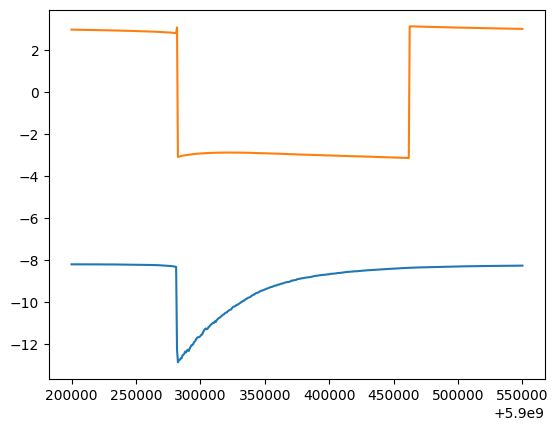

In [342]:
%matplotlib inline
# # Generate the frequency array
plt.plot(freq_array, 20*np.log10(np.abs(s_params)))
plt.plot(freq_array, np.angle(s_params))

plt.show()
